In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 15})
from gradientDescent import ztheta
from joblib import Parallel, delayed, cpu_count
import glob
from scipy.spatial.distance import braycurtis as bcd

In [20]:
class fig_1():
    """
    This class makes figures for analyzing microbiome data.
    """
    
    def __init__(self, data, title, num_latents=None, eta=0.01, num_steps=50000, label='Given', plot_loss=False, plot_reconstruction=False):
         """
        Initializes the `fig_1` object.

        Args:
            data (numpy.ndarray): The microbiome data.
            title (str): The title of the figure.
            num_latents (int, optional): The number of latent variables. Defaults to None.
            eta (float, optional): The learning rate. Defaults to 0.01.
            num_steps (int, optional): The number of optimization steps. Defaults to 50000.
            label (str, optional): The label for the plot. Defaults to 'Given'.
            plot_loss (bool, optional): Whether to plot the loss. Defaults to False.
            plot_reconstruction (bool, optional): Whether to plot the reconstruction. Defaults to False.
        """
        self.data = data
        self.title = title
        self.num_latents = num_latents
        self.eta = eta
        self.num_steps = num_steps
        self.label = label
        self.plot_loss = plot_loss
        self.plot_reconstruction = plot_reconstruction

        if self.num_latents is None:
            self.num_latents = min(self.data.shape[1], self.data.shape[0]) - 1        
        
    def calc_svd(self):
        """
        Calculates the singular value decomposition (SVD) of the microbiome data in the latent space.
        """
        self.obj = ztheta(self.data, self.eta, self.num_steps, self.num_latents, plot=False)
        ztheta_prod = np.matmul(self.obj.z, self.obj.theta)
        self.log_data = -ztheta_prod        

        # Perform SVD
        _, self.S_original, _ = sp.linalg.svd(self.log_data, compute_uv=True)

        # Extract the first 50 singular values
        self.s_values_1 = self.S_original[:50]

        # Calculate the ratios of the singular values
        ratios_1 = np.array([self.s_values_1[i]/self.s_values_1[i+1] for i in range(self.s_values_1.shape[0] - 1)])

        # Plot the ratios and singular values
        fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 4))
        ax1.scatter(np.arange(1, ratios_1.shape[0]+1), ratios_1, facecolor='none', color='red', label=self.label)
        ax2.scatter(np.arange(1, self.s_values_1.shape[0]+1), self.s_values_1, facecolor='none', color='red', label=self.label)

        ax2.set_xscale('log')
        ax1.set_xscale('log')

        ax1.set_title('SVD ratio for {}'.format(self.title))
        ax2.set_title('SVD values')
        ax1.set_yscale('log')
        ax2.set_yscale('log')

        plt.show()

        data_reconstruct = np.exp(self.log_data)
        norm_sum = np.sum(data_reconstruct, axis=1)
        data_reconstruct = data_reconstruct/norm_sum[:, np.newaxis]

        print('Reconstruction Pearson:', np.corrcoef(data_reconstruct.reshape(-1), self.data.reshape(-1))[0,1])

    def plot_KL_BCD(self):
        """
        Plots the Kullback-Leibler (KL) divergence and Bray-Curtis (BCD) dissimilarity.

        This method calculates the KL divergence and BCD dissimilarity between the original microbiome data and the reconstructed data.
        It then plots the KL divergence and BCD dissimilarity as a function of the number of latent variables.

        Returns:
            None
        """
        def KL_BCD(k):
            # Fit the model to the data
            obj = ztheta(self.data, self.eta, self.num_steps, k, plot=False)

            #Calculate the reconstructed data
            ztheta_prod = np.matmul(obj.z, obj.theta)
            log_data = -ztheta_prod
            data_reconstruct = np.exp(log_data)
            norm_sum = np.sum(data_reconstruct, axis=1)
            data_reconstruct = data_reconstruct/norm_sum[:, np.newaxis]

            #Print the Pearson correlation to check if reconstruction is good
            print('Pearson reconstruction:', np.corrcoef(self.data.reshape(-1), data_reconstruct.reshape(-1))[0,1])

            #Calculate the KL divergence and BCD dissimilarity
            kl = sp.stats.entropy(self.data.T, data_reconstruct.T)
            mean_kl = kl.mean()

            bcd_list = np.array([bcd(x, y) for x, y in zip(data, data_reconstruct)])
            mean_bcd = bcd_list.mean()

            return mean_kl, mean_bcd
        
        num_latents_list = [1, 2, 4, 8]  

        results = Parallel(n_jobs=-1)(delayed(KL_BCD)(i) for i in num_latents_list)
        kl_list = [res[0] for res in results]
        bcd_list = [res[1] for res in results]      
        # Create a new figure and axis object
        fig, ax1 = plt.subplots()

        # Plot the KL divergence values on the left y-axis
        ax1.plot(num_latents_list, kl_list, 'b-')
        ax1.set_xlabel('Number of Latent Variables')
        ax1.set_ylabel('KL Divergence', color='b')
        ax1.tick_params('y', colors='b')

        # Create a twin axis for BCD values
        ax2 = ax1.twinx()

        # Plot the BCD values on the right y-axis
        ax2.plot(num_latents_list, bcd_list, 'r-')
        ax2.set_ylabel('BCD', color='r')
        ax2.tick_params('y', colors='r')

        # Adjust the spacing between the plots
        fig.tight_layout()

        # Show the plot
        plt.show()
    

In [15]:
data = np.array(pd.read_csv('data_files/data_CHKN.csv', index_col=0))
print(data.shape)
obj = fig_1(data, 'Chickens', num_latents=156, eta=0.001, num_steps=50000, plot_reconstruction=True)

(778, 156)


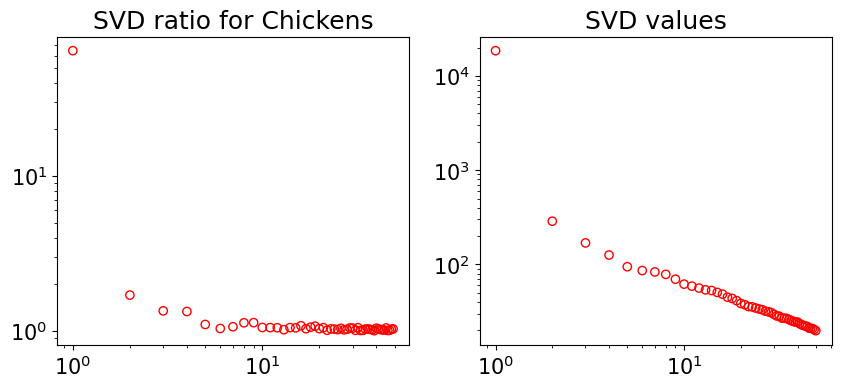

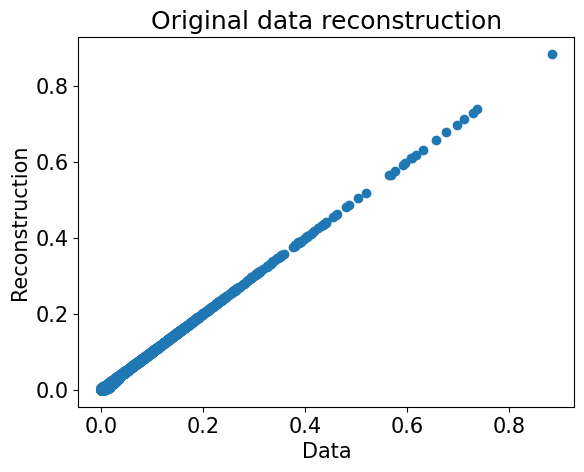

In [16]:
obj.calc_svd()

Pearson reconstruction: 0.5580907218589247
Pearson reconstruction: 0.8646654303793423
Pearson reconstruction: 0.7162856745478506
Pearson reconstruction: 0.9417936979173457


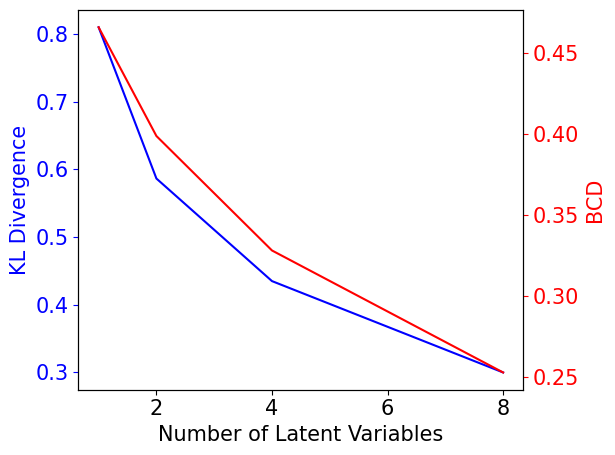

In [14]:
obj.plot_KL_BCD()

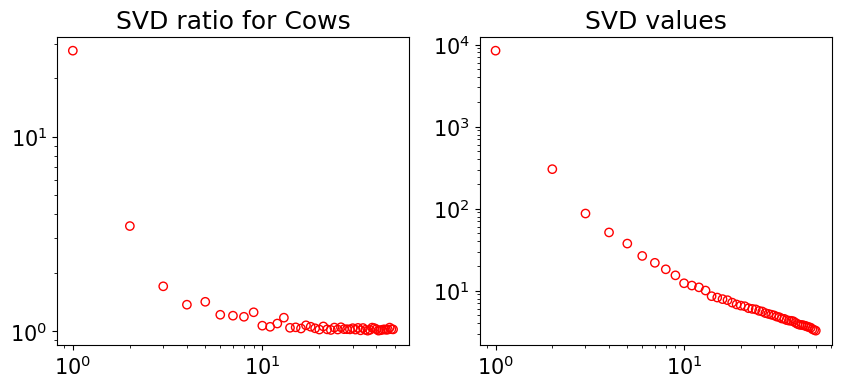

Reconstruction Pearson: 0.9952376020962765
Pearson reconstruction: 0.8953894458465639
Pearson reconstruction: 0.9679999638396404
Pearson reconstruction: 0.990040915852207
Pearson reconstruction: 0.9912066758926704


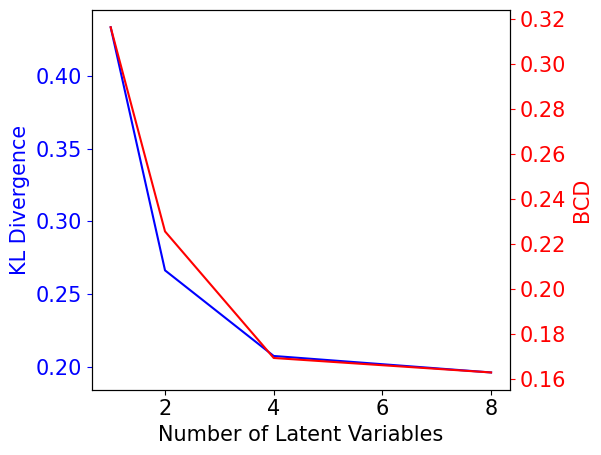

In [21]:
data = np.array(pd.read_csv('data_files/data_COWS.csv', index_col=0))
obj = fig_1(data, 'Cows', num_latents=100, eta=0.00075, num_steps=10000, plot_loss=True, plot_reconstruction=True)
obj.calc_svd()
obj.plot_KL_BCD()

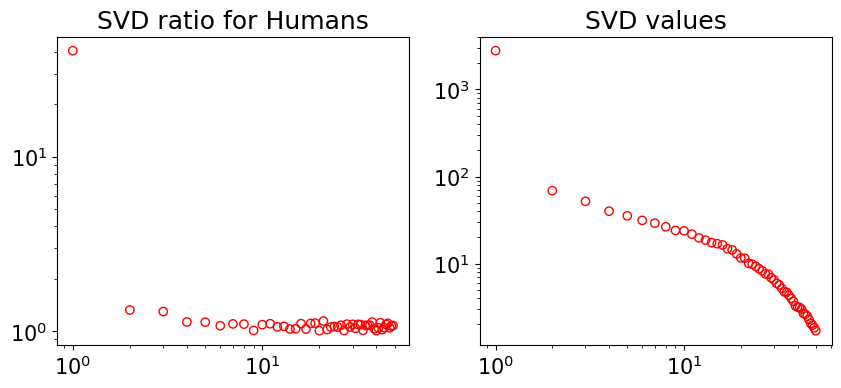

Reconstruction Pearson: 0.99912305543243
Pearson reconstruction: 0.8160845458295128
Pearson reconstruction: 0.95460599624923
Pearson reconstruction: 0.9853408753381506
Pearson reconstruction: 0.9082582186279955


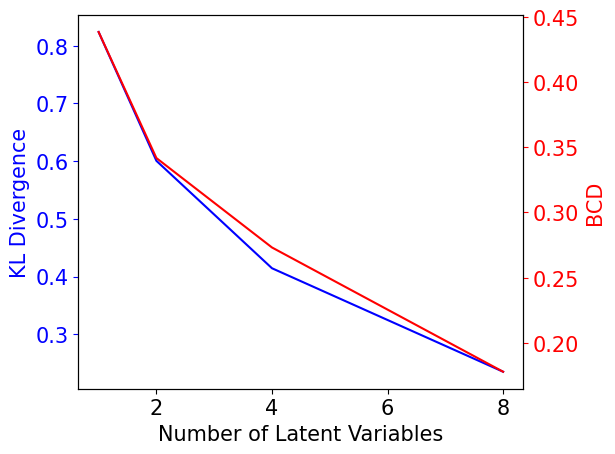

In [23]:
data = np.array(pd.read_csv('data_files/data_HUMN.csv', index_col=0))
obj = fig_1(data, 'Humans', num_latents=100, eta=0.005, num_steps=10000, plot_loss=True, plot_reconstruction=True)
obj.calc_svd()
obj.plot_KL_BCD()